# Atomata results analysis

## Read from database

In [28]:
%load_ext autoreload
%autoreload 2
    
import os.path
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import xgboost
import shap

from python.repository import state_vectors_by_run_id, total_runs, parameters_by_run_id
from python.metric import empirical_probability, complexity, emergence, self_organization

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("results.db3")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analyze complexity

### Compute complexity

In [29]:
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

# Step 1: Function to process each run
def process_run(run_id, con, runs_count):
    print(f"Computing results for run {run_id}")
    con = sqlite3.connect("results.db3")
    state_vectors = state_vectors_by_run_id(run_id, con)
    df_parameters = parameters_by_run_id(run_id, con)
    
    probability_mass = state_vectors["count"].map(lambda state_count: empirical_probability(state_count, runs_count))
    df_parameters["complexity"] = complexity(probability_mass)
    return df_parameters

# Step 2: Main function to parallelize
def parallelized_processing(con):
    total_runs_df = total_runs(con)
    runs_count = total_runs_df.iloc[0]["MAX(run_id)"]
    print(f"Total runs to compute: {runs_count}")

    results = []
    
    # Use ThreadPoolExecutor for parallel execution
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_run, run_id, con, runs_count) for run_id in range(1, runs_count + 1)]
        for future in concurrent.futures.as_completed(futures):
            # Gather results as each thread completes
            results.append(future.result())
    
    return results

results_file = "results.pickle"
if os.path.exists(results_file):
    total_results_df = pd.read_pickle(results_file)
else:
    results = parallelized_processing(con)
    total_results_df = pd.concat(results, ignore_index=True)
    total_results_df.to_pickle(results_file)
buckets_sizes = total_results_df["bucket_size"].unique()
result_dfs = {}
for bucket_size in buckets_sizes:
    result_dfs[bucket_size] = total_results_df[total_results_df["bucket_size"] == bucket_size]
    result_dfs[bucket_size]['complexity_normalized'] = (result_dfs[bucket_size]['complexity'] - result_dfs[bucket_size]['complexity'].min()) / (result_dfs[bucket_size]['complexity'].max() - result_dfs[bucket_size]['complexity'].min())

/tmp/nix-shell.qfMHe6/ipykernel_14100/2560708529.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_dfs[bucket_size]['complexity_normalized'] = (result_dfs[bucket_size]['complexity'] - result_dfs[bucket_size]['complexity'].min()) / (result_dfs[bucket_size]['complexity'].max() - result_dfs[bucket_size]['complexity'].min())
/tmp/nix-shell.qfMHe6/ipykernel_14100/2560708529.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_dfs[bucket_size]['complexity_normalized'] = (result_dfs[bucket_size]['

### Maximum complexity per bucket size

In [30]:
for bucket_size, result_df in result_dfs.items():
    max_complexity = result_df.loc[result_df["complexity"].idxmax()]

    print(f"Best result for bucket size {bucket_size}:")
    print(max_complexity)
    print("\n")

Best result for bucket size 30.0:
run_id                                  3715
amount                                  1000
border                                 600.0
timestep                              0.0002
gravity_constant                         1.0
friction                              0.0001
max_velocity                         40000.0
bucket_size                             30.0
created_at               2024-09-13 18:17:53
complexity                          0.044609
complexity_normalized                    1.0
Name: 3707, dtype: object


Best result for bucket size 20.0:
run_id                                    44
amount                                    10
border                                 400.0
timestep                              0.0002
gravity_constant                         3.0
friction                                 0.0
max_velocity                         60000.0
bucket_size                             20.0
created_at               2024-09-13 18:17:53
comp

### SHAP (SHapley Additive exPlanations)

Bucket size: 30.0


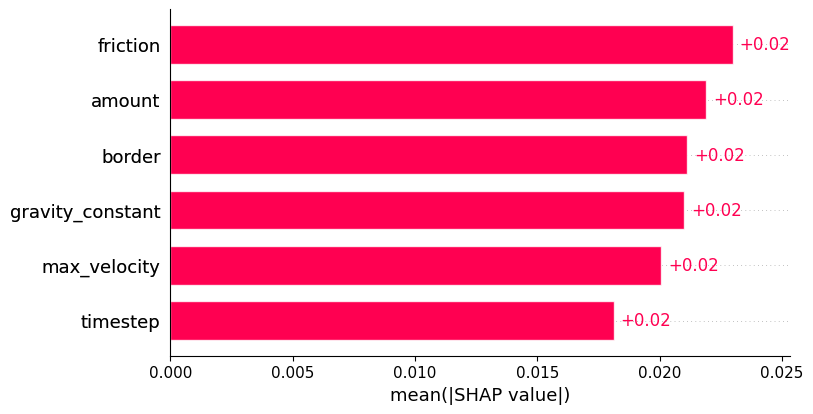

Bucket size: 20.0


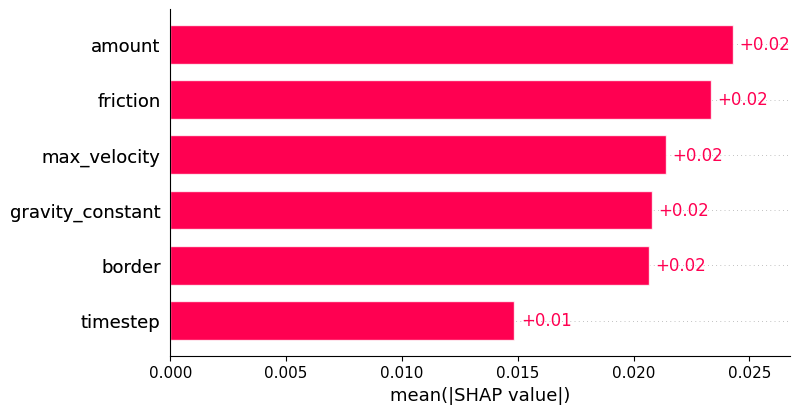

Bucket size: 10.0


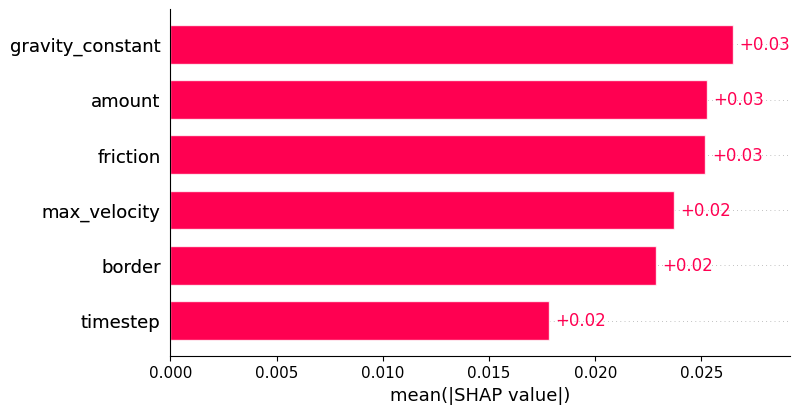

Bucket size: 5.0


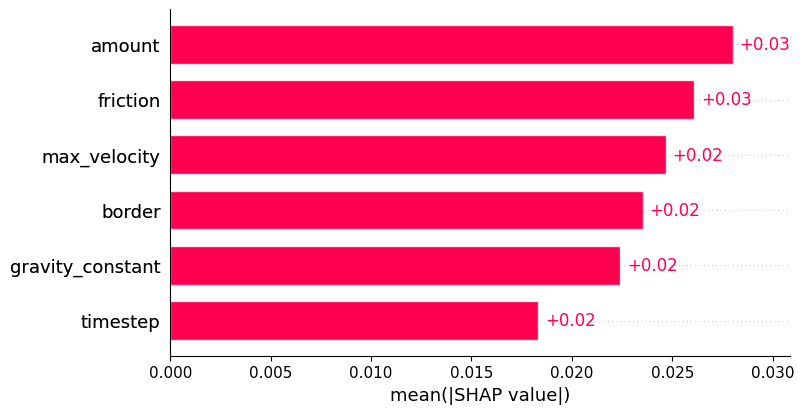

Bucket size: 2.0


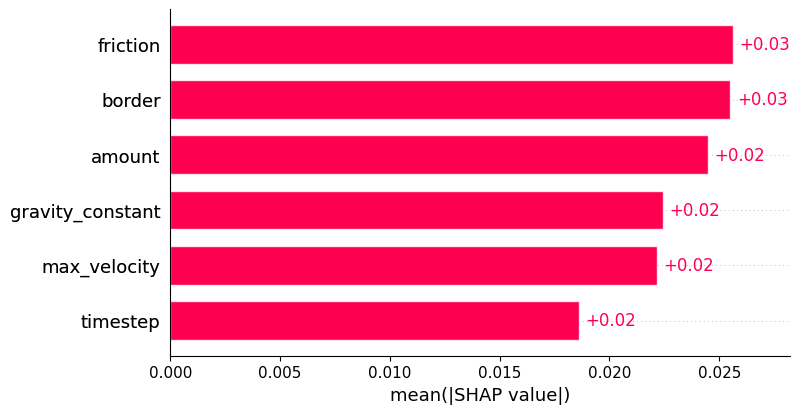

In [31]:
for bucket_size, result_df in result_dfs.items():
    X = result_df.drop(columns=["complexity", "complexity_normalized", "created_at", "run_id", "bucket_size"])
    y = result_df["complexity_normalized"]
    model = xgboost.XGBRegressor().fit(X, y)
    
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    print(f"Bucket size: {bucket_size}")
    shap.plots.bar(shap_values)

## Findings

- None of the parameters does clearly contribute stronger to the outcome than others.
- No correlations between results for different bucket sizes.

### Complexity distribution

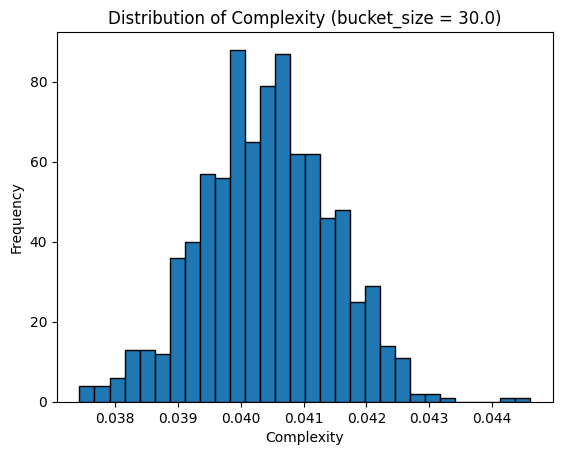

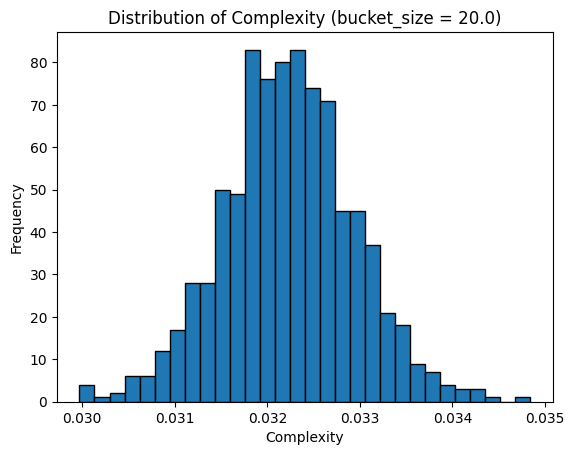

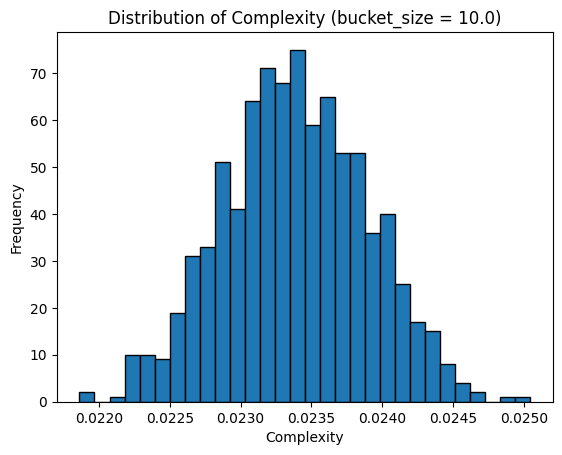

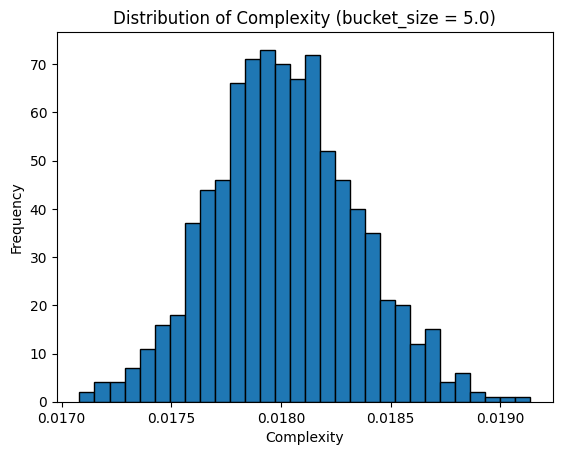

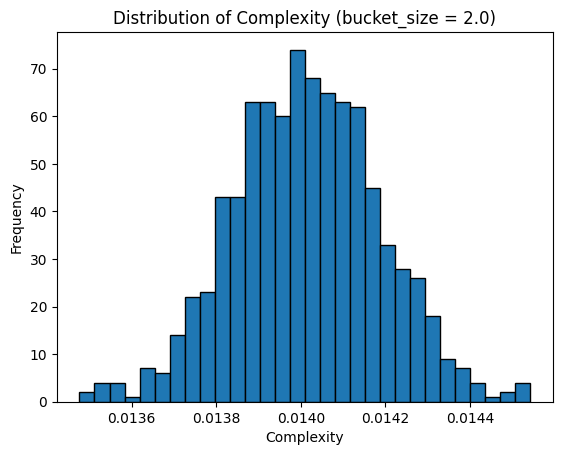

In [22]:
for bucket_size, result_df in result_dfs.items():
    result_df['complexity'].plot(kind='hist', bins=30, edgecolor='black', title=f'Distribution of Complexity (bucket_size = {bucket_size})')
    plt.xlabel('Complexity')
    plt.ylabel('Frequency')
    plt.show()

## Findings

- No matter the bucket size the complexity results are normally distributed.